# Stratified Design
**For this design we aim to distribute sites evenly geographically, given the sampling constraints of the landscape.**

In this notebook we work through an example of producing a stratified design given an input 'invalid area mask'. This mask should be a binary geotiff file, which matches the dimension and resolution of your sample landscape where:
 - Zeros represent invalid pixels
 - Ones represent valid pixels
 
An example map ```InvalidAreasMask.tif```, and can be used to experiment with the code. 

<div class="alert alert-block alert-info">
<b>Tip:</b> To run a code cell, click in the cell and either:
<ul>
  <li>Click 'Run' in the top panel</li>
  <li>OR use the keyboard shortcut 'shift' + 'enter'</li>
</ul>
</div>

<b> Cells must be run sequentially, to ensure all variables are loaded at each stage </b>

### Import required libraries

In [3]:
import os
from osgeo import gdal, osr
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def get_file_info(file_path):
    '''
    Function which extracts a geotiff file as numpy array, and saves geographic projection information
    input: 
        file_path: (str) Path to the file
    output: 
        file_map: (np.array) The extracted map
        nbins: (int) The number of categories in the map
        res: (float) Resolution of the map in meters
        GeoT: The geographic transform used to project the map
        auth_code: The authority code matching the projection
    '''
    file_raw = gdal.Open(file_path)
    prj_info = file_raw.GetProjection()
    GeoT = file_raw.GetGeoTransform(); res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, prj_info


def save_coords_as_shp(self, lbl_coords, out_filename):

    rstr = gdal.Open(self.pan_path, gdal.GA_ReadOnly)
    prj_info = rstr.GetProjection()
    GeoT = rstr.GetGeoTransform()

    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.CreateDataSource(out_filename)


    layer = ds.CreateLayer('', None, ogr.wkbPoint)
    for coords in lbl_coords:

        feature = ogr.Feature(layer.GetLayerDefn())

        # Project row and column (will be for bottom left corner)
        x_proj = coords[0] * GeoT[1] + GeoT[0] 
        y_proj = coords[1] * GeoT[5] + GeoT[3]

        # Shift from bottom left to centre of the pixel
        x_proj += GeoT[1] / 2.0
        y_proj += GeoT[5] / 2.0 

        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(x_proj, y_proj)
        feature.SetGeometry(point)
        layer.CreateFeature(feature)
        feature.Destroy()

    ds.Destroy()
    return     

# User Inputs

<div class="alert alert-block alert-info">
<b>Note:</b> Sections where users can enter their own values are highlighted with #'s. 
    
<b>Current entries link to example files downloaded from Dropbox, which can be used for testing. </b>
</div>

Specify a unique name for the project as `save_folder`. A folder with your chosen name will be created in the ```results``` folder, and all outputs for the design will be saved there. E.g:

In [4]:
######################################
save_folder = 'Stratified_Design_Demo'
######################################

In [5]:
directory = 'results/{}'.format(save_folder)
if not os.path.exists(directory):
    os.makedirs(directory)

# Create unique time stamp to add to file names (to avoid overwriting)
ts = time.gmtime()
ts = time.strftime("%Y_%m_%d_%H%M%S", ts)

print('Results will be saved in the folder {}'.format(directory))
print('Files will start with the time stamp {}'.format(ts))

Results will be saved in the folder results/Stratified_Design_Demo
Files will start with the time stamp 2019_11_11_143020


Enter name of invalid areas mask (`mask_path`). This should be in GeoTiff format. E.g:

In [6]:
######################################
mask_path = 'InvalidAreasMask.tif'
######################################

Enter an integer number of sample sites (`nsp`). E.g

In [7]:
#########
nsp = 25
#########

## Load data
To project the final sites into longitude and latitude locations, we extract geographic information from the invalid areas mask. **If the mask is not saved as a geotiff file, then this will produce an error.**

In [8]:
print('Loading {} ...'.format(mask_path))

mask, nbins, res, GeoT, prj_info = get_file_info(mask_path)

print('\nNumber of categories in mask (should only be two): {}'.format(nbins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(GeoT))

Loading InvalidAreasMask.tif ...


AttributeError: 'NoneType' object has no attribute 'GetProjection'

**Plot mask**: Check that invalid areas are coded as 0, and 1 for valid areas

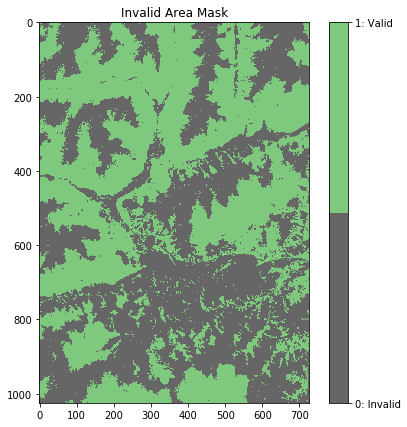

In [28]:
plt.figure(figsize=(7, 7))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.show()

# Generate stratified design
Now we have our inputs, we are ready to generate the design. 

This function iteratively places sites in the study area. We use the euclidean distance transform to calculate the furthest possible distance from other sites, within the valid regions of the landscape.  

In [29]:
def generate_stratified_design(mask, nsp):
    
    # Initialise empty arrays and lists to save design
    imheight, imwidth = mask.shape
    dist_im = np.ones((imheight, imwidth))
    sites = np.ones((imheight, imwidth))
    mask_aux = copy(mask)
    x_vals = []
    y_vals = []

    for i in range(nsp):
        
        print('Plotting site {}'.format(i+1))

        # Make all elements of EDT map in invalid region 0
        dist_im = dist_im * mask_aux

        # Extract coords of pixels with maximum distance value
        dist_mx = list(zip(*np.where(dist_im == dist_im.max())))

        # Choose one max coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Save x and y coords
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Code chosen site to be zero (a feature pixel) in site array
        sites[x, y] = 0

        # Update the euclidean distance transform
        dist_im = ndimage.distance_transform_edt(sites)

    print('Stratified sample design complete!')
    return x_vals, y_vals

We run this funtion to generate the row and column coordinates (x_strat, y_strat) for our sample sites.

In [30]:
x_strat, y_strat = generate_stratified_design(mask, nsp)

Plotting site 1
Plotting site 2
Plotting site 3
Plotting site 4
Plotting site 5
Plotting site 6
Plotting site 7
Plotting site 8
Plotting site 9
Plotting site 10
Plotting site 11
Plotting site 12
Plotting site 13
Plotting site 14
Plotting site 15
Plotting site 16
Plotting site 17
Plotting site 18
Plotting site 19
Plotting site 20
Plotting site 21
Plotting site 22
Plotting site 23
Plotting site 24
Plotting site 25
Stratified sample design complete!


# Results

### Plot Design

We can now check how our design looks over the landscape.

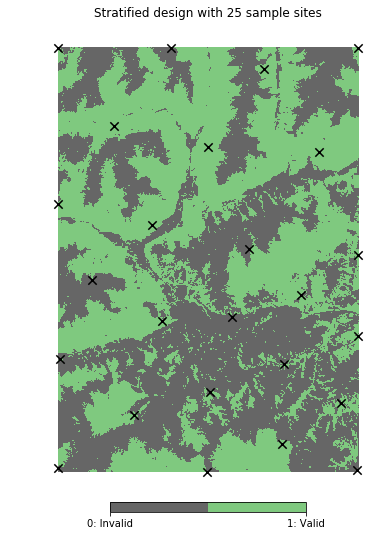

In [31]:
plt.figure(figsize=(7, 9))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('{} design with {} sample sites'.format('Stratified', len(x_strat)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.02, orientation='horizontal', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.scatter(y_strat, x_strat, c='black', marker='x', linewidth=1.5, s=70)
plt.savefig('{}/{}_{}Site_Stratified_Plot.tif'.format(directory, ts, nsp))
plt.show()

As we can see the Stratified Design spreads sites evenly spatially, given the constraints of the valid sample areas. 

<div class="alert alert-block alert-info">
<b>Note:</b> Try going to the top of the notebook and experimenting with different numbers of sample sites (i.e alter the nsp value).  
</div>

### Save the design

The below function converts the (x, y) coordinates into longitude and latitude. Geo-information extracted from the "invalid areas mask" is used to transform the points to long-lat. 

In [34]:
def LongLatConvert(x, y, projection_info, GeoT):
    
    # Project row and column (will be for bottom left corner)
    x_proj = x * GeoT[1] + GeoT[0] 
    y_proj = y * GeoT[5] + GeoT[3]
    
    # Shift from bottom left to centre of the pixel
    x_proj += GeoT[1] / 2.0
    y_proj += GeoT[5] / 2.0 
    
    xy_proj = np.stack((x_proj, y_proj), axis=-1)
    
    # Make spatial coordinate system
    srs = osr.SpatialReference()
    if srs.ImportFromWkt(projection_info) != 0:
        print("Error: cannot import projection '%s'" % projection_info)
        sys.exit(1)
        
    srsLatLong = srs.CloneGeogCS()
    ct = osr.CoordinateTransformation(srs, srsLatLong)
    long, lat, height = list(zip(*ct.TransformPoints(xy_proj)))
    return long, lat

In [35]:
long, lat = LongLatConvert(x_strat, y_strat, prj_info, GeoT)

Now we save the results to a csv file...

In [36]:
# Reformat and save to csv
result = pd.DataFrame()
result['longitude'] = long; result['latitude'] = lat
result['row'] = x_strat; result['col'] = y_strat
result['sampled'] = 0
csv_filename = '{}_{}Site_Stratified.csv'.format(ts, nsp)
result.index += 1
result.to_csv('{}/{}'.format(directory, csv_filename), index_label='site')

print('Design results saved as a csv in {} directory \nFile name: {}'.format(directory, csv_filename))

Design results saved as a csv in results/Stratified_Design_Demo directory 
File name: 2019_10_28_155211_25Site_Stratified.csv


### Example output:

You should now be able to navigate to your results folder and open the csv file using your preferred software. We can load and print the first few lines of the output here as a quick check...

In [40]:
view_csv = pd.read_csv('{}/{}'.format(directory, csv_filename))

In [41]:
view_csv.head()

,site,longitude,latitude,row,col,sampled
0,1,172.510681,-42.484637,660.0,251.0,0
1,2,172.272434,-42.615860,0.0,726.0,0
2,3,172.268461,-42.419761,0.0,0.0,0
3,4,172.645018,-42.610305,1019.0,723.0,0
4,5,172.455640,-42.613678,501.0,726.0,0


In our output csv, the columns consist of:
* A **site** ID
* The coordinates in **longitude** and **latitude**
* The coordinates in **row** and **column** (corresponding to pixels in image)
* A **sampled** column: This is used when generating an *adapted design*. When conducting the survey, sites which have been sampled can be tagged with a 1 in this column. **We go through an example of adapting a partially completed design in the demo-adapted-stratified.ipynb notebook**. 